In [1]:
!pip install sympy==1.7.1
import numpy as np
import math
from matplotlib import pyplot as plt
import pandas as pd
from sympy import Symbol, stats

import models
import melding



def rmse(true, pred):
    out = 0
    for i in range(len(true)):
        out += (true[i] - pred[i]) ** 2
    return (out / len(true)) ** 0.5

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


## Sample importance-resampling algorithm in a univariate case

In order to exemplify the general algorithm, melding is tested on a toy example.
An uninformative prior (uniform pdf) is used to "guess" the values of a gaussian.
Since there is no model, the "pooling" is done with 100% of the observed data and 0% of the model predictions.

Having discrete observations of a single variable, sampling can be done using numpy only.

3.0799999999999974
0.7935999999999986


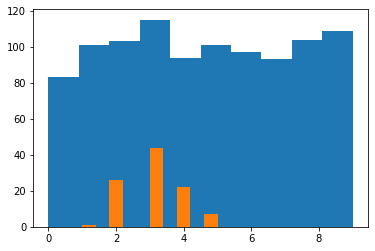

In [2]:
# Sample:
input = np.array([i for i in range(10)])
priors = np.array([1 / 10 for _ in range(10)])

samples = np.zeros(1000, dtype=float)

for i in range(samples.shape[0]):
  samples[i] = np.random.choice(input, p=priors)

plt.hist(samples)

# Importance computation:
weights = np.array([(1 / math.sqrt(2 * math.pi)) * math.e ** (-(x - 3)**2 / 2) for x in samples]) # Instead of pooling, for simplicity we're using the actual observed density.
weights /= np.sum(weights)


# Resampling:
resamples = np.zeros(100, dtype=float)
for i in range(resamples.shape[0]):
  resamples[i] = np.random.choice(samples, p=weights)

plt.hist(resamples)

# Mean and variance of the new samples:
mean = 0
std = 0
for r in resamples:
  mean += r / resamples.shape[0]

for r in resamples:
  std += (r - mean) ** 2 / resamples.shape[0]

print(mean) # Correctly predicts a value close to 3
print(std) # Correctly predicts a value close to 1



## SEIRD predicted by a SIR Toy example

Unlike the first example, in this case (and the following) probabilities are continuous and the pdfs are multivariate.

We assume that each parameter is independent of each other and that it can follow either a normal density (if we know mean and variance) or a uniform density (if we don't know anything).

Although we will know the values for each compartment in practice, for this example, they are treated as variables, also to see how much an increase in number of dimensions in the search space can affect accuracy and the number of samples required.

Our observed data are produced by a SEIRD model with t=100, S=100, E=1, I=0, R=0, D=0, beta=0.1, gamma=0.01, sigma=1, f=0.5, c=0.02, but we are trying to fit them with a simpler SIR model.

We assume a good prior knowledge of S0, I0 and R0 (mean around the correct value and small variance) and complete ignorance about beta, gamma (lower bound of 0 and upper bound of 1) and the outputs (uniform within "reasonable" boundaries).

{'S': 6.590651001083518e-18, 'E': 7.153824412261555e-19, 'I': 0.020373560275763373, 'R': 0.00043348000586730586, 'D': 100.97919295971835}


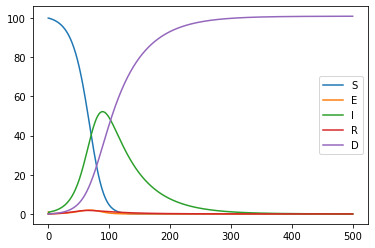

In [3]:
my_seird = models.SEIRD(100, 1, 0, 0, 0, 0.1, 0.01, 1, 0.5, 0.02)
out = my_seird.eval_series(500)

for k, v in out.items():
    plt.plot(range(501), v, label=k)
plt.legend()

    
print(my_seird.eval_last(500))

In [4]:
s = Symbol("s", negative=False)
i = Symbol("i", negative=False)
r = Symbol("r", negative=False)
beta = Symbol("beta", negative=False)
gamma = Symbol("gamma", negative=False)

# Input priors and likelihoods:
S_p = stats.Normal(s, 100, 5)
I_p = stats.Normal(i, 1, 3)
R_p = stats.Normal(r, 0, 10)
Beta_p = stats.Uniform(beta, 0, 1)
Gamma_p = stats.Uniform(gamma, 0, 1)

# Output priors:
S_out_p = stats.Uniform(s, 0, 100)
I_out_p = stats.Uniform(i, 0, 100)
R_out_p = stats.Uniform(r, 0, 100)

#True observations:
true_model = models.SIR(100, 1, 0, 0.05, 0.02)
S_o, I_o, R_o = true_model.eval_last(100).values()


S_out_l = stats.Normal(s, S_o, 3)
I_out_l = stats.Normal(i, I_o, 3)
R_out_l = stats.Normal(r, R_o, 3)

input_prior = melding.Joint_pdf({"S0": S_p, "I0": I_p, "R0": R_p, "beta": Beta_p, "gamma": Gamma_p})
input_likelihood = melding.Joint_pdf({"S0": S_p, "I0": I_p, "R0": R_p, "beta": Beta_p, "gamma": Gamma_p})
output_prior = melding.Joint_pdf({"S": S_out_p, "I": I_out_p, "R": R_out_p})
output_likelihood = melding.Joint_pdf({"S": S_out_l, "I": I_out_l, "R": R_out_l})

In [5]:
model = models.SIR()
model_args = {"t": 100}


samples, means, variances = melding.melding(model, model_args, input_prior, output_prior, input_likelihood, output_likelihood, 10000, 1000)

print(means)
print(variances)

/usr/local/lib/python3.9/site-packages/sympy/stats/rv.py:1104: UserWarning: 
The return type of sample has been changed to return an iterator
object since version 1.7. For more information see
https://github.com/sympy/sympy/issues/19061
  warnings.warn(filldedent(message))


{'S0': 98.42656130915303, 'I0': 2.926332965590052, 'R0': 1.443948583360424, 'beta': 0.038548425680547276, 'gamma': 0.017027814813117978}
{'S0': 11.990268245921202, 'I0': 3.176647500996206, 'R0': 19.372738016392727, 'beta': 0.00039905329952556246, 'gamma': 0.00014795187367690595}


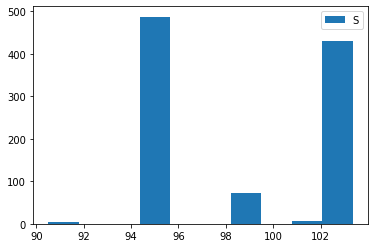

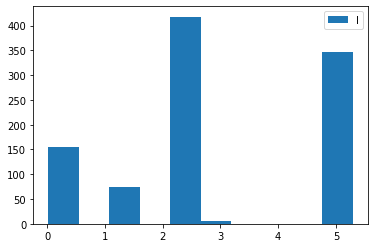

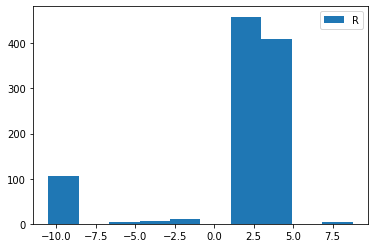

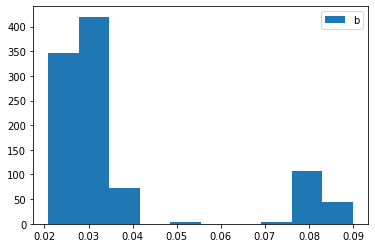

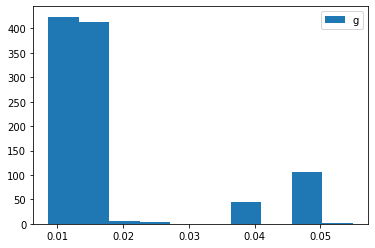

In [6]:
for k, _ in samples[0].items():
    tmp = [s[k] for s in samples]
    plt.hist(tmp)
    plt.legend(k)
    plt.show()

## Melding on real data

For the three models (SIR, SIRD and hidden SEIRD), the values fitted deterministically were used as "seed" for melding (ie. prior probabilities are Gaussians with mean set to the seed). In all cases, variances are empirically set to reduce numerical issues when computing joint probabilities.

### SIR

<AxesSubplot:xlabel='t'>

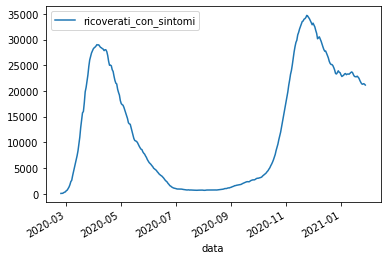

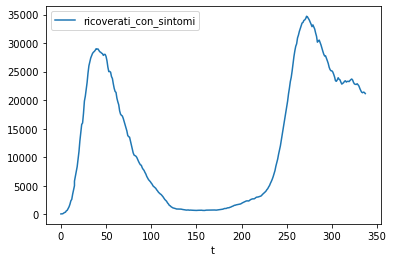

In [7]:

df = pd.read_csv("dpc-covid19-ita-andamento-nazionale.csv", parse_dates=["data"])
df.plot.line("data", "ricoverati_con_sintomi")

df["t"] = (df["data"] - df["data"].loc[0]) // np.timedelta64(1, "D")

df.plot.line("t", "ricoverati_con_sintomi")

     i   r         s
t                   
0  221   8  59999771
1  311  11  59999678
2  385  15  59999600
3  588  62  59999350
4  821  67  59999112
   Unnamed: 0            S0            I0            R0      beta     gamma  \
t                                                                             
0           0  5.999978e+07    209.789577     11.923035  0.426895  0.031425   
1           1  5.999801e+07   1754.534076    228.390698  0.278800  0.041829   
2           2  5.999112e+07   7660.726206   1216.327838  0.220608  0.039746   
3           3  5.997213e+07  23135.450291   4747.708232  0.167516  0.040703   
4           4  5.993552e+07  50833.950736  13657.926284  0.095110  0.029127   

                 data  
t                      
0 2020-02-24 18:00:00  
1 2020-03-02 18:00:00  
2 2020-03-09 18:00:00  
3 2020-03-16 17:00:00  
4 2020-03-23 17:00:00  


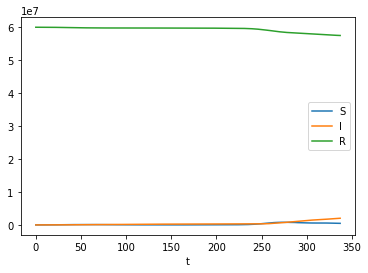

In [8]:
dataset = pd.DataFrame()
dataset["t"] = df["t"]
dataset["i"] = df["totale_positivi"]
dataset["r"] = df["dimessi_guariti"] + df["deceduti"]
dataset["s"] = 60000000 - (dataset["i"] + dataset["r"])

dataset = dataset.set_index("t")

dataset.plot.line()
plt.legend(["S", "I", "R"])
print(dataset.head())

sir_df = pd.read_csv("sir_params_weekly.csv", parse_dates=["data"])
sir_df = sir_df.set_index("t")

print(sir_df.head())

In [9]:
model = models.SIR()
model_args = {"t": 7}

means = {}
variances = {}


s = Symbol("s", negative=False)
i = Symbol("i", negative=False)
r = Symbol("r", negative=False)
beta = Symbol("beta", negative=False)
gamma = Symbol("gamma", negative=False)

for d in range(0, len(dataset) // 7):
    print("Melding window {}-{}...".format(d * 7, (d + 1) * 7))
    window_df = dataset[d * 7: (d + 1) * 7].reset_index()
    # Input priors and likelihoods:
        # Input priors and likelihoods:
    S_p = stats.Normal(s, window_df["s"].loc[0], window_df["s"].std())
    I_p = stats.Normal(i, window_df["i"].loc[0], window_df["i"].std())
    R_p = stats.Normal(r, window_df["r"].loc[0], window_df["r"].std())
    
#     S_l = stats.Normal(s, window_df["s"].loc[0], 1)
#     I_l = stats.Normal(i, window_df["i"].loc[0], 1)
#     R_l = stats.Normal(r, window_df["r"].loc[0], 1)

    alpha = 1 + (1 - 3 * sir_df["beta"].loc[d // 7]) / (sir_df["beta"].loc[d // 7] - 1)
    Beta_p = stats.Beta(beta, alpha, 2)
    alpha = 1 + (1 - 3 * sir_df["gamma"].loc[d // 7]) / (sir_df["gamma"].loc[d // 7] - 1)
    Gamma_p = stats.Beta(gamma, alpha, 2)
    Beta_l = stats.Uniform(beta, 0, 1)
    Gamma_l = stats.Uniform(gamma, 0, 1)

    # Output priors:
    S_out_p = stats.Normal(s, window_df["s"].mean(), window_df["s"].std())
    I_out_p = stats.Normal(i, window_df["i"].mean(), window_df["i"].std())
    R_out_p = stats.Normal(r, window_df["r"].mean(), window_df["r"].std())

    #True observations:
    S_out_l = stats.Normal(s, window_df["s"].loc[len(window_df) - 1], window_df["s"].std())
    I_out_l = stats.Normal(i, window_df["i"].loc[len(window_df) - 1], window_df["i"].std())
    R_out_l = stats.Normal(r, window_df["r"].loc[len(window_df) - 1], window_df["r"].std())
    
    input_prior = melding.Joint_pdf({"S0": S_p, "I0": I_p, "R0": R_p, "beta": Beta_p, "gamma": Gamma_p})
    input_likelihood = melding.Joint_pdf({"S0": S_p, "I0": I_p, "R0": R_p, "beta": Beta_l, "gamma": Gamma_l})
    output_prior = melding.Joint_pdf({"S": S_out_p, "I": I_out_p, "R": R_out_p})
    output_likelihood = melding.Joint_pdf({"S": S_out_l, "I": I_out_l, "R": R_out_l})
    
    _, tmp_mean, tmp_var = melding.melding(model, model_args, input_prior, output_prior, input_likelihood, output_likelihood, 10000, 500)
    for k, v in tmp_mean.items():
        if k not in means:
            means[k] = []
        means[k].append(v)
    for k, v in tmp_var.items():
        if k not in variances:
            variances[k] = []
        variances[k].append(v)

print(means)
print(variances)

Melding window 0-7...


/usr/local/lib/python3.9/site-packages/sympy/stats/rv.py:1104: UserWarning: 
The return type of sample has been changed to return an iterator
object since version 1.7. For more information see
https://github.com/sympy/sympy/issues/19061
  warnings.warn(filldedent(message))


Melding window 7-14...
Melding window 14-21...
Melding window 21-28...
Melding window 28-35...
Melding window 35-42...
Melding window 42-49...
Melding window 49-56...
Melding window 56-63...
Melding window 63-70...
Melding window 70-77...
Melding window 77-84...
Melding window 84-91...
Melding window 91-98...
Melding window 98-105...
Melding window 105-112...
Melding window 112-119...
Melding window 119-126...
Melding window 126-133...
Melding window 133-140...
Melding window 140-147...
Melding window 147-154...
Melding window 154-161...
Melding window 161-168...
Melding window 168-175...
Melding window 175-182...
Melding window 182-189...
Melding window 189-196...
Melding window 196-203...
Melding window 203-210...
Melding window 210-217...
Melding window 217-224...
Melding window 224-231...
Melding window 231-238...
Melding window 238-245...
Melding window 245-252...
Melding window 252-259...
Melding window 259-266...
Melding window 266-273...
Melding window 273-280...
Melding window

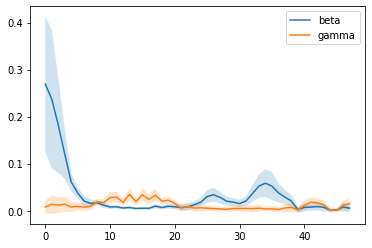

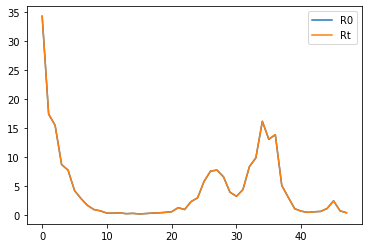

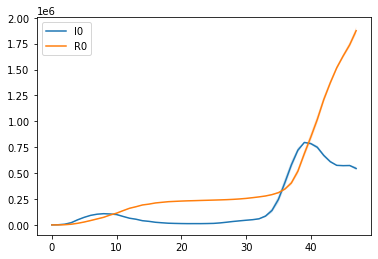

In [10]:
beta_err = np.array(variances["beta"]) ** 0.5
plt.plot(range(0, len(means["beta"])), means["beta"])
plt.fill_between(range(0, len(means["beta"])), means["beta"] - beta_err, means["beta"] + beta_err, alpha=0.2)

gamma_err = np.array(variances["gamma"]) ** 0.5
plt.plot(range(0, len(means["gamma"])), means["gamma"])
plt.fill_between(range(0, len(means["gamma"])), means["gamma"] - gamma_err, means["gamma"] + gamma_err, alpha=0.2)

plt.legend(["beta", "gamma"])
plt.show()

r0 = [means["beta"][i] / means["gamma"][i] for i in range(len(means["beta"]))]
rt = []
for i in range(len(r0)):
    n = dataset.iloc[i]["s"] + dataset.iloc[i]["i"] + dataset.iloc[i]["r"]
    s = dataset.iloc[i]["s"]
    rt.append(r0[i] * n / s)
plt.plot(range(0, len(r0)), r0)
plt.plot(range(0, len(rt)), rt)
plt.legend(["R0", "Rt"])
plt.show()

# beta_err = np.array(variances["S0"]) ** 0.5
# plt.plot(range(0, len(means["S0"])), means["S0"])
# plt.fill_between(range(0, len(means["S0"])), means["S0"] - beta_err, means["S0"] + beta_err, alpha=0.2)

beta_err = np.array(variances["I0"]) ** 0.5
plt.plot(range(0, len(means["I0"])), means["I0"])
plt.fill_between(range(0, len(means["I0"])), means["I0"] - beta_err, means["I0"] + beta_err, alpha=0.2)

beta_err = np.array(variances["R0"]) ** 0.5
plt.plot(range(0, len(means["R0"])), means["R0"])
plt.fill_between(range(0, len(means["R0"])), means["R0"] - beta_err, means["R0"] + beta_err, alpha=0.2)


plt.legend(["I0", "R0"]) # (["S0", "I0", "R0"])

plt.show()

In [11]:
sir_meld = pd.DataFrame(means)
sir_meld = sir_meld.reset_index()
sir_meld = sir_meld.rename(columns={"index":"t"})
dates = (sir_meld["t"] * 7).to_list()
sir_meld["data"] = df["data"][dates].to_list()


print(sir_meld.head())

sir_meld.to_csv("sir_melding_weekly.csv")

sir_meld = pd.DataFrame(variances)
sir_meld = sir_meld.reset_index()
sir_meld = sir_meld.rename(columns={"index":"t"})
dates = (sir_meld["t"] * 7).to_list()
sir_meld["data"] = df["data"][dates].to_list()


print(sir_meld.head())

sir_meld.to_csv("sir_melding_weekly_variances.csv")

   t            S0            I0            R0      beta     gamma  \
0  0  5.999971e+07    318.939299     29.039360  0.269129  0.007854   
1  1  5.999793e+07   1662.008218    372.084839  0.237152  0.013650   
2  2  5.999042e+07   6909.819145   1885.025069  0.182461  0.011821   
3  3  5.997250e+07  21507.640412   6602.310558  0.120755  0.013916   
4  4  5.993579e+07  49527.908823  15695.193292  0.061087  0.007938   

                 data  
0 2020-02-24 18:00:00  
1 2020-03-02 18:00:00  
2 2020-03-09 18:00:00  
3 2020-03-16 17:00:00  
4 2020-03-23 17:00:00  
   t            S0            I0            R0      beta     gamma  \
0  0  1.298329e+05  4.349190e+04  9.914781e+02  0.020802  0.000168   
1  1  1.676835e+06  8.517358e+05  4.386402e+04  0.021666  0.000420   
2  2  1.379297e+07  8.690986e+06  5.827236e+05  0.010457  0.000262   
3  3  5.456159e+07  3.085649e+07  4.195098e+06  0.002787  0.000269   
4  4  5.921373e+07  2.802972e+07  8.291151e+06  0.000417  0.000111   

              

In [12]:
predictions = {}
in_keys = model.get_input_keys()
out_keys = model.get_output_keys()

for i in range(len(dataset) // 7):
    for k in range(len(in_keys)):
        model.input_params[in_keys[k]] = means[in_keys[k]][i]
    tmp = model.eval_series(7 - 1)
    
    for k in range(len(out_keys)):
        if out_keys[k] not in predictions:
            predictions[out_keys[k]] = []
        predictions[out_keys[k]].extend(tmp[out_keys[k]])

        

total_rmse = 0
tmp = rmse(dataset["s"].iloc[:len(predictions["S"])].values, predictions["S"])
print("RMS on S0: {}".format(tmp))
total_rmse += tmp
tmp = rmse(dataset["i"].iloc[:len(predictions["S"])].values, predictions["I"])
print("RMS on I0: {}".format(tmp))
total_rmse += tmp
tmp = rmse(dataset["r"].iloc[:len(predictions["S"])].values, predictions["R"])
print("RMS on R0: {}".format(tmp))
total_rmse += tmp
print("Total RMSE: {}".format(total_rmse))

RMS on S0: 20209.37052449381
RMS on I0: 9455.45355069188
RMS on R0: 18091.123088758977
Total RMSE: 47755.94716394467


### SIRD

In spite of the deterministic seeding and a large number of samples (50000), parameters are not estimated correctly.
This can be either a convergence (more samples are needed), numerical (seeds actually make harder to pool probabilities) or caused by the wrong probabilities (eg. variances too small/large).

In [13]:
dataset = pd.DataFrame()
dataset["t"] = df["t"]
dataset["i"] = df["totale_positivi"]
dataset["r"] = df["dimessi_guariti"]
dataset["d"] = df["deceduti"]
dataset["s"] = 60000000 - (dataset["i"] + dataset["r"])

dataset = dataset.set_index("t")

print(dataset.head())


sird_df = pd.read_csv("sird_params_weekly.csv", parse_dates=["data"])
sird_df = sird_df.set_index("t")

print(sird_df.head())

     i   r   d         s
t                       
0  221   1   7  59999778
1  311   1  10  59999688
2  385   3  12  59999612
3  588  45  17  59999367
4  821  46  21  59999133
   Unnamed: 0            S0            I0           R0           D0      beta  \
t                                                                               
0           0  5.999978e+07    209.578168     3.211345     9.387089  0.426704   
1           1  5.999801e+07   1752.552716   179.821367    53.120293  0.278601   
2           2  5.999113e+07   7661.580611   717.908075   497.066077  0.220613   
3           3  5.997213e+07  23140.650101  2650.266370  2086.557060  0.167559   
4           4  5.993552e+07  50839.706353  7557.109430  6086.340740  0.095144   

      gamma         f                data  
t                                          
0  0.023563  0.007335 2020-02-24 18:00:00  
1  0.026636  0.014638 2020-03-02 18:00:00  
2  0.021655  0.018132 2020-03-09 18:00:00  
3  0.022950  0.017876 2020-03-16 17:0

In [15]:
model = models.SIRD()
model_args = {"t": 7}

means = {}
variances = {}


s = Symbol("s", negative=False)
i = Symbol("i", negative=False)
r = Symbol("r", negative=False)
d_sym = Symbol("d", negative=False)
beta = Symbol("beta", negative=False)
gamma = Symbol("gamma", negative=False)
f = Symbol("f", negative=False)

for d in range(0, len(dataset) // 7):
    print("Melding window {}-{}...".format(d * 7, (d + 1) * 7))
    window_df = dataset[d * 7: (d + 1) * 7].reset_index()
    # Input priors and likelihoods:
    S_p = stats.Normal(s, window_df["s"].loc[0], window_df["s"].std())
    I_p = stats.Normal(i, window_df["i"].loc[0], window_df["i"].std())
    R_p = stats.Normal(r, window_df["r"].loc[0], window_df["r"].std())
    D_p = stats.Normal(d_sym, window_df["d"].loc[0], window_df["d"].std())
    
#     S_l = stats.Normal(s, window_df["s"].loc[0], 1)
#     I_l = stats.Normal(i, window_df["i"].loc[0], 1)
#     R_l = stats.Normal(r, window_df["r"].loc[0], 1)

    alpha = 1 + (1 - 3 * sird_df["beta"].loc[d // 7]) / (sird_df["beta"].loc[d // 7] - 1)
    Beta_l = stats.Beta(beta, alpha, 2)
    alpha = 1 + (1 - 3 * sird_df["gamma"].loc[d // 7]) / (sird_df["gamma"].loc[d // 7] - 1)
    Gamma_l = stats.Beta(gamma, alpha, 2)
    alpha = 1 + (1 - 3 * sird_df["f"].loc[d // 7]) / (sird_df["f"].loc[d // 7] - 1)
    F_l = stats.Beta(f, alpha, 2)
#     Beta_p = stats.Uniform(beta, 0, 1)
#     Gamma_p = stats.Uniform(gamma, 0, 1)
#     F_p = stats.Uniform(f, 0, 1)
    Beta_p = stats.Uniform(beta, 0, 1)
    Gamma_p = stats.Uniform(gamma, 0, 1)
    F_p = stats.Uniform(f, 0, 1)

    # Output priors:
    S_out_p = stats.Normal(s, window_df["s"].loc[len(window_df) - 1], window_df["s"].std())
    I_out_p = stats.Normal(i, window_df["i"].loc[len(window_df) - 1], window_df["i"].std())
    R_out_p = stats.Normal(r, window_df["r"].loc[len(window_df) - 1], window_df["r"].std())
    D_out_p = stats.Normal(d_sym, window_df["d"].loc[len(window_df) - 1], window_df["d"].std())

    #True observations:
    S_out_l = stats.Normal(s, window_df["s"].loc[len(window_df) - 1], window_df["s"].std())
    I_out_l = stats.Normal(i, window_df["i"].loc[len(window_df) - 1], window_df["i"].std())
    R_out_l = stats.Normal(r, window_df["r"].loc[len(window_df) - 1], window_df["r"].std())
    D_out_l = stats.Normal(d_sym, window_df["d"].loc[len(window_df) - 1], window_df["d"].std())
    
    input_prior = melding.Joint_pdf({"S0": S_p, "I0": I_p, "R0": R_p, "D0": D_p, "beta": Beta_p, "gamma": Gamma_p, "f": F_p})
    input_likelihood = melding.Joint_pdf({"S0": S_p, "I0": I_p, "R0": R_p, "D0": D_p, "beta": Beta_l, "gamma": Gamma_l, "f": F_l})
    output_prior = melding.Joint_pdf({"S": S_out_p, "I": I_out_p, "R": R_out_p, "D": D_out_p})
    output_likelihood = melding.Joint_pdf({"S": S_out_l, "I": I_out_l, "R": R_out_l, "D": D_out_l})
    
    _, tmp_mean, tmp_var = melding.melding(model, model_args, input_prior, output_prior, input_likelihood, output_likelihood, 50000, 2000, debug=False)
    for k, v in tmp_mean.items():
        if k not in means:
            means[k] = []
        means[k].append(v)
    for k, v in tmp_var.items():
        if k not in variances:
            variances[k] = []
        variances[k].append(v)

print(means)
print(variances)

Melding window 0-7...


/usr/local/lib/python3.9/site-packages/sympy/stats/rv.py:1104: UserWarning: 
The return type of sample has been changed to return an iterator
object since version 1.7. For more information see
https://github.com/sympy/sympy/issues/19061
  warnings.warn(filldedent(message))


Melding window 7-14...
Melding window 14-21...
Melding window 21-28...
Melding window 28-35...
Melding window 35-42...
Melding window 42-49...
Melding window 49-56...
Melding window 56-63...
Melding window 63-70...
Melding window 70-77...
Melding window 77-84...
Melding window 84-91...
Melding window 91-98...
Melding window 98-105...
Melding window 105-112...
Melding window 112-119...
Melding window 119-126...
Melding window 126-133...
Melding window 133-140...
Melding window 140-147...
Melding window 147-154...
Melding window 154-161...
Melding window 161-168...
Melding window 168-175...
Melding window 175-182...
Melding window 182-189...
Melding window 189-196...
Melding window 196-203...
Melding window 203-210...
Melding window 210-217...
Melding window 217-224...
Melding window 224-231...
Melding window 231-238...
Melding window 238-245...
Melding window 245-252...
Melding window 252-259...
Melding window 259-266...
Melding window 266-273...
Melding window 273-280...
Melding window

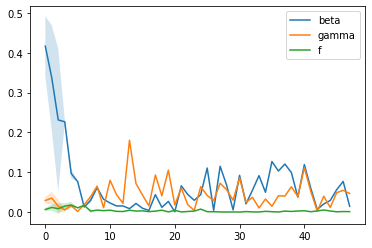

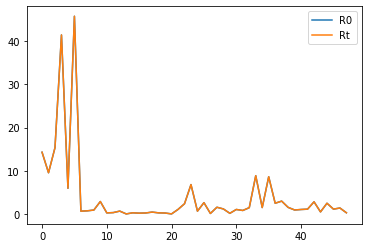

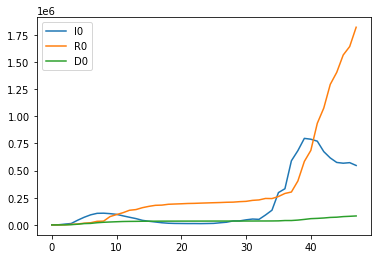

In [16]:
beta_err = np.array(variances["beta"]) ** 0.5
plt.plot(range(0, len(means["beta"])), means["beta"])
plt.fill_between(range(0, len(means["beta"])), means["beta"] - beta_err, means["beta"] + beta_err, alpha=0.2)

gamma_err = np.array(variances["gamma"]) ** 0.5
plt.plot(range(0, len(means["gamma"])), means["gamma"])
plt.fill_between(range(0, len(means["gamma"])), means["gamma"] - gamma_err, means["gamma"] + gamma_err, alpha=0.2)

f_err = np.array(variances["f"]) ** 0.5
plt.plot(range(0, len(means["f"])), means["f"])
plt.fill_between(range(0, len(means["f"])), means["f"] - f_err, means["f"] + f_err, alpha=0.2)

plt.legend(["beta", "gamma", "f"])
plt.show()

r0 = [means["beta"][i] / means["gamma"][i] for i in range(len(means["beta"]))]
rt = []
for i in range(len(r0)):
    n = dataset.iloc[i]["s"] + dataset.iloc[i]["i"] + dataset.iloc[i]["r"]
    s = dataset.iloc[i]["s"]
    rt.append(r0[i] * n / s)
plt.plot(range(0, len(r0)), r0)
plt.plot(range(0, len(rt)), rt)
plt.legend(["R0", "Rt"])
plt.show()

# beta_err = np.array(variances["S0"]) ** 0.5
# plt.plot(range(0, len(means["S0"])), means["S0"])
# plt.fill_between(range(0, len(means["S0"])), means["S0"] - beta_err, means["S0"] + beta_err, alpha=0.2)

beta_err = np.array(variances["I0"]) ** 0.5
plt.plot(range(0, len(means["I0"])), means["I0"])
plt.fill_between(range(0, len(means["I0"])), means["I0"] - beta_err, means["I0"] + beta_err, alpha=0.2)

beta_err = np.array(variances["R0"]) ** 0.5
plt.plot(range(0, len(means["R0"])), means["R0"])
plt.fill_between(range(0, len(means["R0"])), means["R0"] - beta_err, means["R0"] + beta_err, alpha=0.2)

beta_err = np.array(variances["D0"]) ** 0.5
plt.plot(range(0, len(means["D0"])), means["D0"])
plt.fill_between(range(0, len(means["D0"])), means["D0"] - beta_err, means["D0"] + beta_err, alpha=0.2)


plt.legend(["I0", "R0", "D0"]) # (["S0", "I0", "R0", "D0"])

plt.show()

In [17]:
sird_meld = pd.DataFrame(means)
sird_meld = sird_meld.reset_index()
sird_meld = sird_meld.rename(columns={"index":"t"})
dates = (sird_meld["t"] * 7).to_list()
sird_meld["data"] = df["data"][dates].to_list()


print(sird_meld.head())

sird_meld.to_csv("sird_melding_weekly.csv")

sird_meld = pd.DataFrame(variances)
sird_meld = sird_meld.reset_index()
sird_meld = sird_meld.rename(columns={"index":"t"})
dates = (sird_meld["t"] * 7).to_list()
sird_meld["data"] = df["data"][dates].to_list()


print(sird_meld.head())

sird_meld.to_csv("sird_melding_weekly_variances.csv")

   t            S0            I0           R0           D0      beta  \
0  0  5.999993e+07    166.049959   -16.649242     6.889094  0.416844   
1  1  5.999721e+07   1023.836646   128.522204    97.543873  0.337266   
2  2  5.998988e+07   7055.408153   674.727096   446.403690  0.231431   
3  3  5.997952e+07  13105.052428  5007.607634  2313.277919  0.226891   
4  4  5.993680e+07  43360.920353  8458.454827  6370.486049  0.096859   

      gamma         f                data  
0  0.029128  0.006547 2020-02-24 18:00:00  
1  0.035240  0.011679 2020-03-02 18:00:00  
2  0.015061  0.008533 2020-03-09 18:00:00  
3  0.005476  0.014912 2020-03-16 17:00:00  
4  0.016225  0.017905 2020-03-23 17:00:00  
   t            S0            I0             R0            D0      beta  \
0  0  1.717938e+05  2.911048e+03     871.240623  8.725043e+01  0.005632   
1  1  6.262032e+05  1.621944e+05   41731.053884  9.062978e+03  0.017446   
2  2  1.417768e+07  1.082940e+07   65941.176719  6.514017e+04  0.032090   
3  

In [18]:
predictions = {}
in_keys = model.get_input_keys()
out_keys = model.get_output_keys()

for i in range(len(dataset) // 7):
    for k in range(len(in_keys)):
        model.input_params[in_keys[k]] = means[in_keys[k]][i]
    tmp = model.eval_series(7 - 1)
    
    for k in range(len(out_keys)):
        if out_keys[k] not in predictions:
            predictions[out_keys[k]] = []
        predictions[out_keys[k]].extend(tmp[out_keys[k]])

        

total_rmse = 0
tmp = rmse(dataset["s"].iloc[:len(predictions["S"])].values, predictions["S"])
print("RMS on S0: {}".format(tmp))
total_rmse += tmp
tmp = rmse(dataset["i"].iloc[:len(predictions["S"])].values, predictions["I"])
print("RMS on I0: {}".format(tmp))
total_rmse += tmp
tmp = rmse(dataset["r"].iloc[:len(predictions["S"])].values, predictions["R"])
print("RMS on R0: {}".format(tmp))
total_rmse += tmp
print("Total RMSE: {}".format(total_rmse))

RMS on S0: 61963.56320498664
RMS on I0: 32989.344505330904
RMS on R0: 37939.390295007564
Total RMSE: 132892.2980053251


### SEIRD with hidden E compartment

Like the SIRD case, melding fails (in an even more evident way). In order to rule out the ill-behaved time series of sigma (which the deterministic fitting failed to determine since no informations on E where available), an additional test with smoothed time series was performed (with no improvement on the outcome of melding).

In [27]:
dataset = pd.DataFrame()
dataset["t"] = df["t"]
dataset["i"] = df["totale_positivi"]
dataset["r"] = df["dimessi_guariti"]
dataset["d"] = df["deceduti"]
dataset["s"] = 60000000 - (dataset["i"] + dataset["r"])

dataset = dataset.set_index("t")

print(dataset.head())


seird_df = pd.read_csv("hidden_seird_params_weekly_fixed_sigma.csv", parse_dates=["data"])
seird_df = seird_df.set_index("t")

print(seird_df.head())

     i   r   d         s
t                       
0  221   1   7  59999778
1  311   1  10  59999688
2  385   3  12  59999612
3  588  45  17  59999367
4  821  46  21  59999133
   Unnamed: 0            S0            E0            I0           R0  \
t                                                                      
0           0  5.999975e+07   2184.003636     84.210083    32.714202   
1           1  5.999796e+07   7646.437269   1463.787914   293.132205   
2           2  5.999083e+07  30738.099873   6713.405983   937.169060   
3           3  5.997202e+07  62905.723028  21703.957035  2918.146718   
4           4  5.993550e+07  68954.898510  49901.973001  7649.039990   

            D0      beta         gamma     sigma       c             f  \
t                                                                        
0    18.571429  0.388663  3.867354e-35  0.102998  0.0001  2.280091e-37   
1   164.724056  0.268703  1.207166e-02  0.103000  0.0001  5.128009e-04   
2   713.905789  0.212876

Deterministic predictions for the hidden SEIRD model contain a lot of spurious oscillations, these give the melding a very low probability which underflows and causes divisions by zero.

To solve the problem, the dataset is smoothed, before feeding it to the Bayesian melding approach.

<AxesSubplot:xlabel='t'>

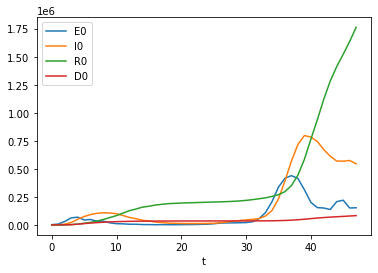

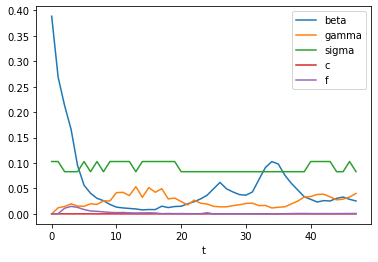

In [28]:
seird_df[["E0", "I0", "R0", "D0"]].plot()
seird_df[["beta", "gamma", "sigma", "c", "f"]].plot()

# seird_df = seird_df.ewm(alpha=0.05).mean()

# seird_df[["E0", "I0", "R0", "D0"]].plot()
# seird_df[["beta", "gamma", "sigma", "c", "f"]].plot()

In [29]:
model = models.HiddenSEIRD()
model_args = {"t": 7}

means = {}
variances = {}


s = Symbol("s", negative=False)
e = Symbol("e", negative=False)
i = Symbol("i", negative=False)
r = Symbol("r", negative=False)
d_symbol = Symbol("d", negative=False)
beta = Symbol("beta", negative=False)
gamma = Symbol("gamma", negative=False)
sigma = Symbol("sigma", negative=False)
f = Symbol("f", negative=False)
c = Symbol("c", negative=False)

for d in range(0, len(dataset) // 7):
    print("Melding window {}-{}...".format(d * 7, (d + 1) * 7))
    window_df = dataset[d * 7: (d + 1) * 7].reset_index()
    # Input priors and likelihoods:
        # Input priors and likelihoods:
    S_p = stats.Normal(s, window_df["s"].loc[0], window_df["s"].std())
    E_p = stats.Normal(e, seird_df["E0"].loc[d // 7], seird_df["E0"].std()) #Exposed are taken from the deterministic fit
    
    I_p = stats.Normal(i, window_df["i"].loc[0], window_df["i"].std())
    R_p = stats.Normal(r, window_df["r"].loc[0], window_df["r"].std())
    D_p = stats.Normal(d_symbol, window_df["d"].loc[0], window_df["d"].std())
    
    E_l = stats.Uniform(e, 0, 2 * seird_df["E0"].loc[d // 7])
    
#     S_l = stats.Normal(s, window_df["s"].loc[0], 1)
#     I_l = stats.Normal(i, window_df["i"].loc[0], 1)
#     R_l = stats.Normal(r, window_df["r"].loc[0], 1)

#     alpha = 1 + (1 - 3 * seird_df["beta"].loc[d // 7]) / (seird_df["beta"].loc[d // 7] - 1)
#     Beta_p = stats.Beta(beta, alpha, 2)
#     alpha = 1 + (1 - 3 * seird_df["gamma"].loc[d // 7]) / (seird_df["gamma"].loc[d // 7] - 1)
#     Gamma_p = stats.Beta(gamma, alpha, 2)
#     alpha = 1 + (1 - 3 * seird_df["sigma"].loc[d // 7]) / (seird_df["sigma"].loc[d // 7] - 1)
#     Sigma_p = stats.Beta(sigma, alpha, 2)
#    Sigma_p = stats.Normal(sigma, 0.09302, 0.014462) # Computed as the mean of 1/8.2 and 1/15.6 and considering the confidence interval as 95% (ie. these values lie inside x +- 2 sigma, so their sum is divided by 4 to get sigma)
   # Sigma_p = stats.Uniform(sigma, 0, 1)

#     alpha = 1 + (1 - 3 * sir_df["f"].loc[d // 7]) / (sir_df["f"].loc[d // 7] - 1)
#     F_p = stats.Beta(f, alpha, 2)
#     alpha = 1 + (1 - 3 * sir_df["c"].loc[d // 7]) / (sir_df["c"].loc[d // 7] - 1)
#     C_p = stats.Beta(c, alpha, 2)

    Beta_l = stats.Uniform(beta, 0, 1)
    Gamma_l = stats.Uniform(gamma, 0, 1)
    Sigma_l = stats.Uniform(sigma, 0.083, 0.103)
    F_l = stats.Uniform(f, 0, 0.1)
    C_l = stats.Uniform(c, 0, 0.01)

    # Output priors:
    S_out_p = stats.Normal(s, window_df["s"].mean(), window_df["s"].std())
    I_out_p = stats.Normal(i, window_df["i"].mean(), window_df["i"].std())
    R_out_p = stats.Normal(r, window_df["r"].mean(), window_df["r"].std())
    D_out_p = stats.Normal(d_symbol, window_df["d"].mean(), window_df["d"].std())

    #True observations:
    S_out_l = stats.Normal(s, window_df["s"].loc[len(window_df) - 1], window_df["s"].std())
    I_out_l = stats.Normal(i, window_df["i"].loc[len(window_df) - 1], window_df["i"].std())
    R_out_l = stats.Normal(r, window_df["r"].loc[len(window_df) - 1], window_df["r"].std())
    D_out_l = stats.Normal(d_symbol, window_df["d"].loc[len(window_df) - 1], window_df["d"].std())
    
    input_prior = melding.Joint_pdf({"S0": S_p, "E0": E_p, "I0": I_p, "R0": R_p, "D0": D_p, "beta": Beta_l, "gamma": Gamma_l, "sigma": Sigma_l, "f": F_l, "c": C_l})
    input_likelihood = melding.Joint_pdf({"S0": S_p, "E0": E_l, "I0": I_p, "R0": R_p, "D0": D_p, "beta": Beta_l, "gamma": Gamma_l, "sigma": Sigma_l, "f": F_l, "c": C_l})
    output_prior = melding.Joint_pdf({"S": S_out_p, "I": I_out_p, "R": R_out_p, "D": D_out_p})
    output_likelihood = melding.Joint_pdf({"S": S_out_l, "I": I_out_l, "R": R_out_l, "D": D_out_l})
    
    _, tmp_mean, tmp_var = melding.melding(model, model_args, input_prior, output_prior, input_likelihood, output_likelihood, 10000, 2000)
    for k, v in tmp_mean.items():
        if k not in means:
            means[k] = []
        means[k].append(v)
    for k, v in tmp_var.items():
        if k not in variances:
            variances[k] = []
        variances[k].append(v)

print(means)
print(variances)

Melding window 0-7...


/usr/local/lib/python3.9/site-packages/sympy/stats/rv.py:1104: UserWarning: 
The return type of sample has been changed to return an iterator
object since version 1.7. For more information see
https://github.com/sympy/sympy/issues/19061
  warnings.warn(filldedent(message))


Melding window 7-14...
Melding window 14-21...
Melding window 21-28...
Melding window 28-35...
Melding window 35-42...
Melding window 42-49...
Melding window 49-56...
Melding window 56-63...
Melding window 63-70...
Melding window 70-77...
Melding window 77-84...
Melding window 84-91...
Melding window 91-98...
Melding window 98-105...
Melding window 105-112...
Melding window 112-119...
Melding window 119-126...
Melding window 126-133...
Melding window 133-140...
Melding window 140-147...
Melding window 147-154...


/app/notebooks/melding.py:75: RuntimeWarning: invalid value encountered in true_divide
  weights /= np.sum(weights)


Melding window 154-161...
Melding window 161-168...
Melding window 168-175...
Melding window 175-182...
Melding window 182-189...
Melding window 189-196...
Melding window 196-203...
Melding window 203-210...
Melding window 210-217...
Melding window 217-224...
Melding window 224-231...
Melding window 231-238...
Melding window 238-245...
Melding window 245-252...
Melding window 252-259...
Melding window 259-266...
Melding window 266-273...
Melding window 273-280...
Melding window 280-287...
Melding window 287-294...
Melding window 294-301...
Melding window 301-308...
Melding window 308-315...
Melding window 315-322...
Melding window 322-329...
Melding window 329-336...
{'S0': [59999430.09470066, 59995791.384646505, 59996958.766910635, 59967147.18002068, 59945731.82409619, 59900505.803454906, 59890492.317481786, 59867715.83272543, 59849309.52693607, 59826095.2849124, 59816754.89153307, 59811692.12703823, 59804393.56456696, 59802983.94760809, 59800209.62646624, 59798902.164396286, 59797029

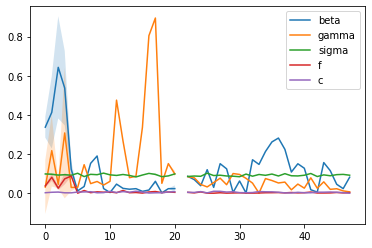

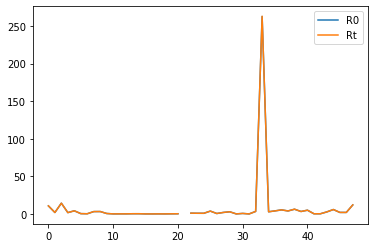

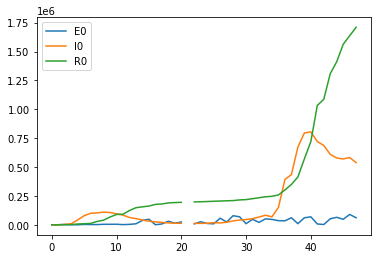

In [30]:
beta_err = np.array(variances["beta"]) ** 0.5
plt.plot(range(0, len(means["beta"])), means["beta"])
plt.fill_between(range(0, len(means["beta"])), means["beta"] - beta_err, means["beta"] + beta_err, alpha=0.2)

gamma_err = np.array(variances["gamma"]) ** 0.5
plt.plot(range(0, len(means["gamma"])), means["gamma"])
plt.fill_between(range(0, len(means["gamma"])), means["gamma"] - gamma_err, means["gamma"] + gamma_err, alpha=0.2)

sigma_err = np.array(variances["sigma"]) ** 0.5
plt.plot(range(0, len(means["sigma"])), means["sigma"])
plt.fill_between(range(0, len(means["sigma"])), means["sigma"] - sigma_err, means["sigma"] + sigma_err, alpha=0.2)

f_err = np.array(variances["f"]) ** 0.5
plt.plot(range(0, len(means["f"])), means["f"])
plt.fill_between(range(0, len(means["f"])), means["f"] - f_err, means["f"] + f_err, alpha=0.2)

c_err = np.array(variances["c"]) ** 0.5
plt.plot(range(0, len(means["c"])), means["c"])
plt.fill_between(range(0, len(means["c"])), means["c"] - c_err, means["c"] + c_err, alpha=0.2)

plt.legend(["beta", "gamma", "sigma", "f", "c"])
plt.show()

r0 = [means["beta"][i] / means["gamma"][i] for i in range(len(means["beta"]))]
rt = []
for i in range(len(r0)):
    n = dataset.iloc[i]["s"] + dataset.iloc[i]["i"] + dataset.iloc[i]["r"]
    s = dataset.iloc[i]["s"]
    rt.append(r0[i] * n / s)
plt.plot(range(0, len(r0)), r0)
plt.plot(range(0, len(rt)), rt)
plt.legend(["R0", "Rt"])
plt.show()

# beta_err = np.array(variances["S0"]) ** 0.5
# plt.plot(range(0, len(means["S0"])), means["S0"])
# plt.fill_between(range(0, len(means["S0"])), means["S0"] - beta_err, means["S0"] + beta_err, alpha=0.2)

beta_err = np.array(variances["E0"]) ** 0.5
plt.plot(range(0, len(means["E0"])), means["E0"])
plt.fill_between(range(0, len(means["E0"])), means["E0"] - beta_err, means["E0"] + beta_err, alpha=0.2)

beta_err = np.array(variances["I0"]) ** 0.5
plt.plot(range(0, len(means["I0"])), means["I0"])
plt.fill_between(range(0, len(means["I0"])), means["I0"] - beta_err, means["I0"] + beta_err, alpha=0.2)

beta_err = np.array(variances["R0"]) ** 0.5
plt.plot(range(0, len(means["R0"])), means["R0"])
plt.fill_between(range(0, len(means["R0"])), means["R0"] - beta_err, means["R0"] + beta_err, alpha=0.2)


plt.legend(["E0", "I0", "R0"]) # (["S0", "E0", "I0", "R0"])

plt.show()

In [31]:
sir_meld = pd.DataFrame(means)
sir_meld = sir_meld.reset_index()
sir_meld = sir_meld.rename(columns={"index":"t"})
dates = (sir_meld["t"] * 7).to_list()
sir_meld["data"] = df["data"][dates].to_list()


print(sir_meld.head())

sir_meld.to_csv("hidden_seird_melding_weekly.csv")

sir_meld = pd.DataFrame(variances)
sir_meld = sir_meld.reset_index()
sir_meld = sir_meld.rename(columns={"index":"t"})
dates = (sir_meld["t"] * 7).to_list()
sir_meld["data"] = df["data"][dates].to_list()


print(sir_meld.head())

sir_meld.to_csv("hidden_seird_melding_weekly_variances.csv")

   t            S0           E0            I0           R0           D0  \
0  0  5.999943e+07    27.292012     42.789531   -32.222733     8.657505   
1  1  5.999579e+07   888.486776    516.069756   130.536143    -2.824466   
2  2  5.999696e+07  3217.173081   3916.218509   666.753695   221.145354   
3  3  5.996715e+07  1004.870412   9342.320897  2324.918673  2270.622115   
4  4  5.994573e+07   469.158750  42681.428286  7389.182581  5249.656255   

       beta     gamma     sigma         f         c                data  
0  0.337208  0.031543  0.098320  0.037230  0.002485 2020-02-24 18:00:00  
1  0.412804  0.217511  0.096707  0.081318  0.004695 2020-03-02 18:00:00  
2  0.642756  0.044964  0.092527  0.025423  0.005723 2020-03-09 18:00:00  
3  0.536798  0.307812  0.094524  0.073288  0.002022 2020-03-16 17:00:00  
4  0.122095  0.029414  0.091814  0.087623  0.001856 2020-03-23 17:00:00  
   t            S0             E0            I0             R0             D0  \
0  0  2.857046e+03    12

In [32]:
predictions = {}
in_keys = model.get_input_keys()
out_keys = model.get_output_keys()

for i in range(len(dataset) // 7):
    for k in range(len(in_keys)):
        model.input_params[in_keys[k]] = means[in_keys[k]][i]
    tmp = model.eval_series(7 - 1)
    
    for k in range(len(out_keys)):
        if out_keys[k] not in predictions:
            predictions[out_keys[k]] = []
        predictions[out_keys[k]].extend(tmp[out_keys[k]])

        

total_rmse = 0
tmp = rmse(dataset["s"].iloc[:len(predictions["S"])].values, predictions["S"])
print("RMS on S0: {}".format(tmp))
total_rmse += tmp
tmp = rmse(dataset["i"].iloc[:len(predictions["S"])].values, predictions["I"])
print("RMS on I0: {}".format(tmp))
total_rmse += tmp
tmp = rmse(dataset["r"].iloc[:len(predictions["S"])].values, predictions["R"])
print("RMS on R0: {}".format(tmp))
total_rmse += tmp
tmp = rmse(dataset["d"].iloc[:len(predictions["S"])].values, predictions["D"])
print("RMS on D0: {}".format(tmp))
total_rmse += tmp
print("Total RMSE: {}".format(total_rmse))

ZeroDivisionError: float division by zero

### Motivations for the choice of distributions

The Erlang distribution has support in $[0, \infty)$ and two parameters: $\lambda$ and $k$.
Its mean is $\mu = \frac{k}{\lambda}$ and its std deviation is $\sigma = \frac{k}{\lambda^2}$.

As a result we can manipulate the formulas to get the values of $k$ and $\lambda$ so that the mean and variances match our observed data:

$k = \frac{\mu^2}{\sigma}$

$\lambda = \frac{\mu}{\sigma}$

The Beta distribution has support in $(0, 1)$ and two parameters: $\alpha$ and $\beta$.
Its mean is $\frac{\alpha}{\alpha + \beta}$.

In order to reduce the degrees of freedom we can set $\beta = 2$ and vary $\alpha > 1$ in order to get the desired mean, while preserving a concavity on the PDF.

As a result, with similar algebraic manipulations we get:

$\beta = 2$

$\alpha = 1 + \frac{1 - 3 \mu}{\mu - 1}$.

The Erlang distribution was applied to compartments and the Beta distribution to rates in order to have domains matching with supports.

To improve convergence, the likelihood on $\sigma$, $f$ and $c$ of the hidden SEIRD model were constrained similarly to the deterministic case.

### Results
Using both beta and Erlang distributions, even SIR fails to converge.

Using beta and normal distributions, SIR achieved a performance similar to the normal baseline, SIRD achieved worse performances and SEIRD failed (due to incompatibilities between the heuristic chosen for setting $\alpha$ and $\beta$ and the deterministic seeding).

The final SEIRD was computed discarding the seed values (ie. using a uniform prior), but the values of $\sigma$, $f$ and $c$ were bounded in $\sigma \in [0.083, 0.103], f \in [0, 0.1], c \in [0, 0.01]$.

(Note: compared to previous executions, samples for the Hidden SEIRD model were reduced to $10^4$ in order to speed up computation and the exponential moving average on the seeded values was removed.)